
What factors seem to be most important in driving total # of reservations for the vehicles?
(technology type, pricing, number of car photos, street parking, car description length)

How does the car's technology type seem to affect reservations?

# ------------------------------------------

## Libraries

In [218]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
% matplotlib inline

# ------------------------------------------------

## Loading the data

In [219]:
vehicles_df = pd.read_csv("/Users/Hedi/Documents/vehicles.csv")
reservations_df = pd.read_csv("/Users/Hedi/Documents/reservations.csv")

# ---------------------------------------------------

# Table of Content:

## Part A: Overview of the vehicle & reservation tables
## Part B: Joining the tables
## Part C: Exploratory data analysis
## Part D: Levers to drive # of reservations
## Part E: Effect of car's technology on reservations

# --------------------------------------------------------------------------------------------

# Part A: High Overview

# --------------------------------------------------------------------------------------------

### Vehicle Table (each row represents a unique vehicle)

    + Check for missing values
    + Check duplicates
    + Check outliers (scatter plot)

In [220]:
# There are no missing values
vehicles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
vehicle_id           1000 non-null int64
technology           1000 non-null int64
actual_price         1000 non-null float64
recommended_price    1000 non-null int64
num_images           1000 non-null int64
street_parked        1000 non-null int64
description          1000 non-null int64
dtypes: float64(1), int64(6)
memory usage: 54.8 KB


In [221]:
# There are 1000 vehicles / no vehicle_id duplicates
vehicles_df['vehicle_id'].nunique()

1000

In [222]:
vehicles_df.head()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description
0,1,1,67.85,59,5,0,7
1,2,0,100.70,53,5,0,224
2,3,0,74.00,74,4,1,21
3,4,0,135.00,75,1,0,184
4,5,0,59.36,53,2,1,31


### Reservation Table (each row represents a unique reservation)

In [223]:
# There are no missing values
reservations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6376 entries, 0 to 6375
Data columns (total 2 columns):
vehicle_id          6376 non-null int64
reservation_type    6376 non-null int64
dtypes: int64(2)
memory usage: 99.7 KB


In [224]:
# There are 911 unique vehicle id
# A vehicle can be rented many times & in different ways (hourly,daily and weekly)
# Observation: 89 vehicles have never been booked
reservations_df['vehicle_id'].nunique()

911

In [225]:
# Each row represents one reservation
reservations_df.head()

,vehicle_id,reservation_type
0,208,1
1,601,3
2,993,1
3,423,2
4,685,3


In [226]:
# Goal: Join the reservation & vehicle tables
# Let's group by vehicle id so that each row repsents a vehicle
rentals_df = reservations_df.groupby('vehicle_id').apply(lambda x: pd.Series({
    '#_Hourly_rentals': len(x[x.reservation_type==1]),
    '#_Daily_rentals': len(x[x.reservation_type==2]),
    '#_Weekly_rentals': len(x[x.reservation_type==3]),
    '#_reservations': len(x)    
})).reset_index()

rentals_df.head()

,vehicle_id,#_Daily_rentals,#_Hourly_rentals,#_Weekly_rentals,#_reservations
0,1,0,1,0,1
1,2,3,4,0,7
2,3,9,1,7,17
3,4,0,1,1,2
4,5,1,0,1,2


In [227]:
# Check point:rentals_df contains 911 unique vehicle_id 
# We didn't lose any vehicle while grouping by vehicle_id
rentals_df['vehicle_id'].nunique()

911

## -----------------------------------------------------------------------------------------------------------

# Part B: Joining the vehicle and rental tables

# --------------------------------------------------------------------------------------------

In [228]:
# Let's join the vehicles and rentals df
# vehicle_df contains 1000 vehicles and rentals_df contains 911 vehicles
# Important to use a LEFT join cause there are vehicles that have never been booked 
# Using a INNER join would remove this information
vehicle_rentals_df = vehicles_df.merge(rentals_df,how='left',on='vehicle_id')

In [229]:
# We replace the null values by 0
vehicle_rentals_df = vehicle_rentals_df.fillna(0)

In [230]:
# No more null values
vehicle_rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 11 columns):
vehicle_id           1000 non-null int64
technology           1000 non-null int64
actual_price         1000 non-null float64
recommended_price    1000 non-null int64
num_images           1000 non-null int64
street_parked        1000 non-null int64
description          1000 non-null int64
#_Daily_rentals      1000 non-null float64
#_Hourly_rentals     1000 non-null float64
#_Weekly_rentals     1000 non-null float64
#_reservations       1000 non-null float64
dtypes: float64(5), int64(6)
memory usage: 93.8 KB


In [231]:
vehicle_rentals_df.head()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,#_Daily_rentals,#_Hourly_rentals,#_Weekly_rentals,#_reservations
0,1,1,67.85,59,5,0,7,0.0,1.0,0.0,1.0
1,2,0,100.70,53,5,0,224,3.0,4.0,0.0,7.0
2,3,0,74.00,74,4,1,21,9.0,1.0,7.0,17.0
3,4,0,135.00,75,1,0,184,0.0,1.0,1.0,2.0
4,5,0,59.36,53,2,1,31,1.0,0.0,1.0,2.0


## -----------------------------------------------------------------------------------------------------------

# Part C: Exploratory Data Analysis

    + The number of hourly,daily and weekly reservations seems to follow a
      Power Law distribution (it has long tail, it's decaying exponentially ) 
    
    + Those four variables seem to be identically distributed.

# --------------------------------------------------------------------------------------------

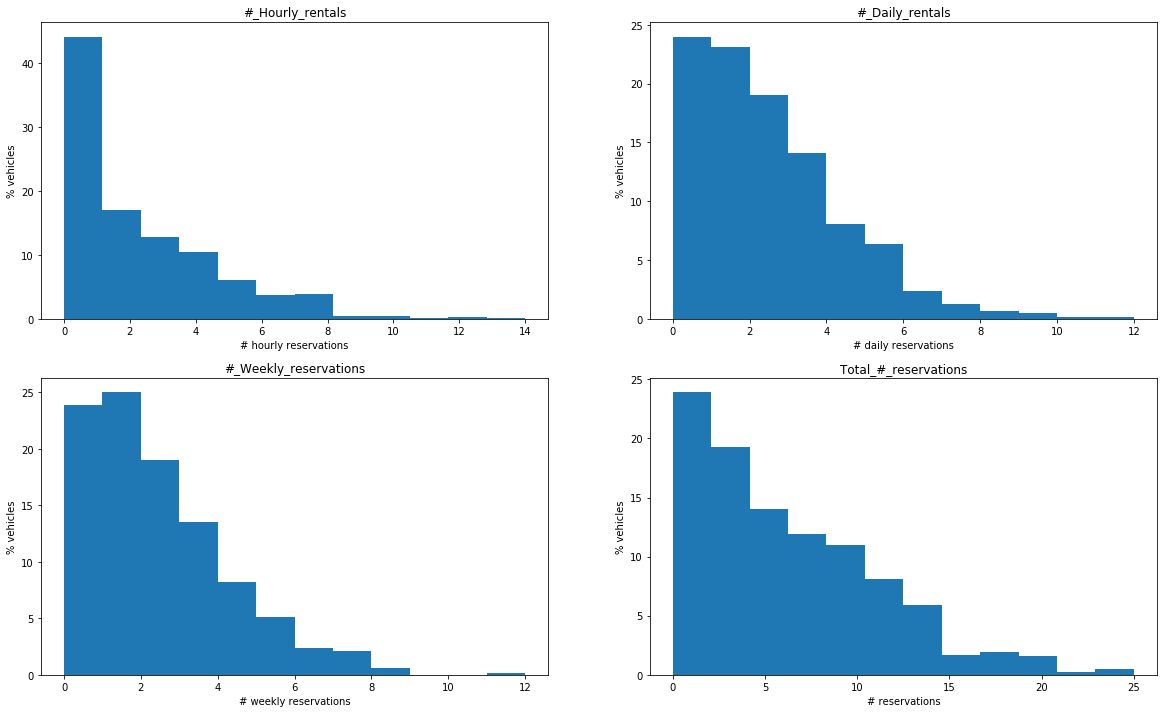

In [232]:
nvehicles = len(vehicle_rentals_df['vehicle_id'])

fig = plt.figure(figsize = (20,12))
fig.add_subplot(221)
plt.title("#_Hourly_rentals")
plt.hist(vehicle_rentals_df['#_Hourly_rentals'],bins=12,weights=np.ones(nvehicles)*100.0/nvehicles)
plt.xlabel("# hourly reservations")
plt.ylabel("% vehicles")

fig.add_subplot(222)
plt.title("#_Daily_rentals")
plt.hist(vehicle_rentals_df['#_Daily_rentals'],bins=12,weights=np.ones(nvehicles)*100.0/nvehicles)
plt.xlabel("# daily reservations")
plt.ylabel("% vehicles")

fig.add_subplot(223)
plt.title("#_Weekly_reservations")
plt.hist(vehicle_rentals_df['#_Weekly_rentals'],bins=12,weights=np.ones(nvehicles)*100.0/nvehicles)
plt.xlabel("# weekly reservations")
plt.ylabel("% vehicles")

fig.add_subplot(224)
plt.title("Total_#_reservations")
plt.hist(vehicle_rentals_df['#_reservations'],bins=12,weights=np.ones(nvehicles)*100.0/nvehicles)
plt.xlabel("# reservations")
plt.ylabel("% vehicles")

plt.savefig('Distribution of the total number of reservations.png')

#plt.xlabel("# hourly reservations")
#plt.ylabel("% vehicles")

In [233]:
# The command describe gives different statistics of the features
vehicle_rentals_df.describe()

,vehicle_id,technology,actual_price,recommended_price,num_images,street_parked,description,#_Daily_rentals,#_Hourly_rentals,#_Weekly_rentals,#_reservations
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.170000,87.940730,62.206000,3.008000,0.511000,90.792000,2.057000,2.339000,1.980000,6.376000
std,288.819436,0.375821,29.724589,16.082544,1.348983,0.500129,76.948644,1.935846,2.263449,1.853925,4.861302
min,1.000000,0.000000,32.760000,35.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,250.750000,0.000000,64.942500,49.000000,2.000000,0.000000,25.000000,1.000000,1.000000,1.000000,3.000000
50%,500.500000,0.000000,83.930000,62.000000,3.000000,1.000000,57.500000,2.000000,2.000000,2.000000,5.000000
75%,750.250000,0.000000,107.010000,76.000000,4.000000,1.000000,158.000000,3.000000,4.000000,3.000000,9.000000
max,1000.000000,1.000000,174.440000,90.000000,5.000000,1.000000,250.000000,12.000000,14.000000,12.000000,25.000000


# ----------------------------------------------------------------------------------------

## Part D: What are the key levers driving the total # of reservations?

    I'm going to start with the conclusion and then describe the methodology that led me 
    to this conclusion:
    
    The percentage change between the actual & recommended price is the key lever
    that Turo can use to drive the total number of reservations. Followed by the 
    actual price, the description and the number of images inputed by the car owner. 
    The presence of street parking and the "instantly bookable" technology come at last.

# --------------------------------------------------------------------------------------------

    + Correlation matrix is useful to get some intuition right away for the relationships (or lack thereof) 
      between all of our variables.
    + Sanity check that all features are not highly correlated -> Might hurt our RF model (take extreme case
      where we have 100 duplicates and 2 other features, RF choose randomly k<N features to make the split
      A tree that has 100 k same feature will perform very very bad)
    
    + The recommended price and actual price are highly correlated.
    + The technology and the actual price are negatively correlated. This means that cars that have the tech
      tend to be at lower prices. An intuition might be that a "Tesla" owner do not want his/her car to be 
      unlocked with a mobile phone.
      

In [234]:
vehicle_rentals_df[[col for col in vehicle_rentals_df.columns if col not in ["vehicle_id",'#_hourly_rentals',
                                                                             '#_Hourly_rentals',
                                                                             '#_Daily_rentals',
                                                                             '#_Weekly_rentals',
                                                                             '#_reservations']]].corr()

,technology,actual_price,recommended_price,num_images,street_parked,description
technology,1.000000,-0.461930,-0.411390,-0.004660,-0.004633,0.033000
actual_price,-0.461930,1.000000,0.759358,-0.064753,0.004764,-0.015089
recommended_price,-0.411390,0.759358,1.000000,-0.046492,0.013034,0.012820
num_images,-0.004660,-0.064753,-0.046492,1.000000,-0.006065,0.010074
street_parked,-0.004633,0.004764,0.013034,-0.006065,1.000000,-0.008186
description,0.033000,-0.015089,0.012820,0.010074,-0.008186,1.000000


### Hypothesis: 

            A feature that tells if the car rental is overpriced (actual price > recommended price) 
            /underpricded (recommended price > actual price) might help our model perform better.

    + Feature Engineering: Because the actual & recommended price are highly correlated, the recommended price
      is replaced by the percentage change between the actual & recommended price.

In [235]:
vehicle_rentals_df['price_percentage_change [%]'] = \
 100*(vehicle_rentals_df['actual_price']-vehicle_rentals_df['recommended_price'])/vehicle_rentals_df['recommended_price']

In [236]:
# To understand what are the most important features that drive the # reservations
# the predictive model has to do first a good job at predicting the # reservations
# The first step is to split the predictors and the target

X = vehicle_rentals_df[[col for col in vehicle_rentals_df.columns if col not in ["vehicle_id",'recommended_price',
                                                                             '#_Hourly_rentals',
                                                                             '#_Daily_rentals',
                                                                             '#_Weekly_rentals',
                                                                             '#_reservations']]]
target =  vehicle_rentals_df['#_reservations']

In [237]:
from sklearn.model_selection import train_test_split

# In order to be able to see how good a model will generalize 
# we need to split the dataset into train & test
X_train,X_test,y_train,y_test = train_test_split(X,target,test_size=0.25)

  Why did I choose RF?
  
   + Decision tree models are not sensitive to features of different magnitudes/scale. I didn't have to
     normalize my data.
     
   + Feature importance is very interpretable.
   
   + RF is a non-linear model. It means that it's able to map non-linear relationship of the features to 
     predict the target variable.
  
  

In [238]:
from sklearn.ensemble import RandomForestRegressor


# For regression trees, the algorithm optimizes the split using the MSE
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [239]:
# The predictions are obtained using the test/train sets
y_predictions = rfr.predict(X_test)
y_predictions_train = rfr.predict(X_train)

In [240]:
# A baseline model that always predicts the mean was built
# It's used to evaluate how our RF model is doing.
baseline_predictions = np.array([vehicle_rentals_df['#_reservations'].mean()]*len(y_predictions))

In [241]:
from sklearn.metrics import mean_absolute_error

# TEST MAE
mean_absolute_error(y_test,y_predictions)

3.5428000000000002

In [242]:
# TRAIN MAE
mean_absolute_error(y_train,y_predictions_train)

1.3704000000000003

In [243]:
# Baseline model MAE
mean_absolute_error(y_test,baseline_predictions)

4.0681279999999997

  + To evaluate how good are the predictions of the model
    the MAE was computed. MAE is an absolute value that 
    describes how off are in average our predictions

  + In this case, the MAE = 3.69, this means that in average
    the predicted number of reservations are off by 3 units compared to the
    true number of reservation. 
    
  + Now, the question is: is our model doing a good job or not?
    To answer this question, one should compute the MAE of the baseline model
    which is 4.1. Therefore, our model is doing better than the baseline model.
    As interest of time, we'll consider that it's good enough.
    

  + Now we are pretty confident that our random forest regressor is doing a good job
    we want to extract the feature importance.
    
  + The importance of a feature is computed as the (normalized) total reduction of the criterion (MSE)
    brought by that feature.

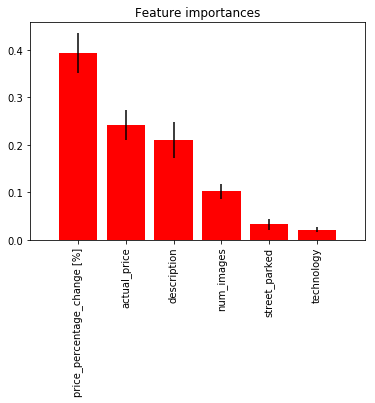

In [244]:
importances = rfr.feature_importances_

# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 
std = np.std(np.array([estimator.feature_importances_ for estimator in rfr.estimators_]), axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

plt.savefig('Feature importance.png')

## --------------------------------------------------------------------------------------------

## Part D: How does the car's technology type seem to affect reservations?

In this part, we're going to explore and formulate hypothesis.

However, we will not be able to prove causation relationships but we will talk about ways to get to do that.

    1) Hypotheses are formulated. 
    2) Hypotheses are tested using the available data. 
    3) Finally, some limitations are discussed.

# ----------------------------------------------------------------------------

In [245]:
# 17% of the cars do have the "instantly bookable"tech and 83% do not.
vehicle_rentals_df['technology'].value_counts()

0    830
1    170
Name: technology, dtype: int64

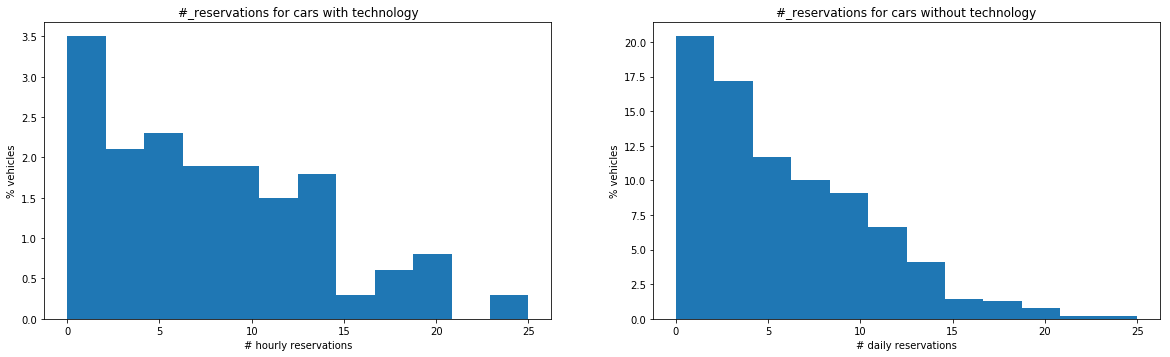

In [246]:
# Always good to make sure that the two enitites that we will compare
# are identically distributed.

nvehicles_technology = len(vehicle_rentals_df[vehicle_rentals_df['technology']==1])
nvehicles_no_technology = len(vehicle_rentals_df[vehicle_rentals_df['technology']==0])

fig = plt.figure(figsize = (20,12))
fig.add_subplot(221)
plt.title("#_reservations for cars with technology")
plt.hist(vehicle_rentals_df[vehicle_rentals_df['technology']==1]['#_reservations'],\
             bins=12,weights=np.ones(nvehicles_technology)*100.0/nvehicles)
plt.xlabel("# hourly reservations")
plt.ylabel("% vehicles")

fig.add_subplot(222)
plt.title("#_reservations for cars without technology")
plt.hist(vehicle_rentals_df[vehicle_rentals_df['technology']==0]['#_reservations'],\
         bins=12,weights=np.ones(nvehicles_no_technology)*100.0/nvehicles)
plt.xlabel("# daily reservations")
plt.ylabel("% vehicles")

## ------------------------------

### Hypothesis 1:

    The cars are "instantly bookable" and unlockable with mobile phone show a higher
    avergae number of reservations compared to the cars without this technology.

# -----------------------------

In [247]:
# The instantly booklable cars have an avergae number of reserations of 7.8
vehicle_rentals_df[vehicle_rentals_df["technology"]==1]["#_reservations"].mean()

7.841176470588235

In [248]:
# The cars that are NOT instantly bookable have an avergae number of reserations of 6.1
vehicle_rentals_df[vehicle_rentals_df["technology"]==0]["#_reservations"].mean()

6.075903614457832

    + The mean is very sensitive to ourliers. Also, because our sample size differs a lot (170 VS 830 vehicles)
      it would be helpful to compute the confidence interval in order to assess the 
      uncertainty of our mean measuremnents.
    
    + Also, Part C showed that the technology feature is negatively correlated with price. This means that cars 
      with the instantly bookable technology are actually cheaper. Therefore, it's trickier to prove causality
      in this case. Maybe, the reason why the average number of reservations is higher is due to the lower price.
      -> We would need to make a cohort analysis to compare cars with/without the techology 
        but that are booked at the same price.
    
    

In [249]:
import scipy.stats as stats
import math

sample_size = vehicle_rentals_df[vehicle_rentals_df["technology"]==1]["#_reservations"].size
sample = vehicle_rentals_df[vehicle_rentals_df["technology"]==1]["#_reservations"]
sample_mean = sample.mean()

t_critical = stats.t.ppf(q = 0.95, df=sample_size-1)  # Get the t-critical value*

print("t-critical value:")                  # Check the t-critical value
print(t_critical)                        

sample_stdev = sample.std()    # Get the sample standard deviation

sigma = sample_stdev/math.sqrt(sample_size)  # Standard deviation estimate
margin_of_error = t_critical * sigma

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval for the vehicles with the technology:")
print(confidence_interval)

t-critical value:
1.65391994188
Confidence interval for the vehicles with the technology:
(7.0918835652422905, 8.5904693759341804)


In [250]:
sample_size = vehicle_rentals_df[vehicle_rentals_df["technology"]==0]["#_reservations"].size
sample = vehicle_rentals_df[vehicle_rentals_df["technology"]==0]["#_reservations"]
sample_mean = sample.mean()

t_critical = stats.t.ppf(q = 0.95, df=sample_size-1)  # Get the t-critical value*

print("t-critical value:")                  # Check the t-critical value
print(t_critical)                        

sample_stdev = sample.std()    # Get the sample standard deviation

sigma = sample_stdev/math.sqrt(sample_size)  # Standard deviation estimate
margin_of_error = t_critical * sigma

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval for the vehicles without the technology:")
print(confidence_interval)

t-critical value:
1.6466937762
Confidence interval for the vehicles without the technology:
(5.8150057111730717, 6.3368015177425914)


(-1, 2)

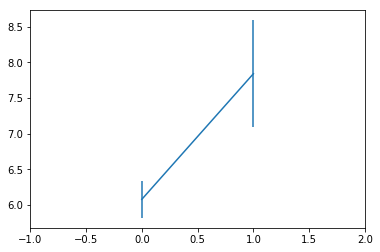

In [251]:
# One way to visualize the confidence intervals of both sample means
# The confidence interval lower bound of sample with technolofy is sitll higher than the 
# CI upper bound of the sample without the tech.


data_m=np.array([vehicle_rentals_df[vehicle_rentals_df["technology"]==0]["#_reservations"].mean(),\
                 vehicle_rentals_df[vehicle_rentals_df["technology"]==1]["#_reservations"].mean()])   #(Means of your data)
data_df=np.array([829,169])   #(Degree-of-freedoms of your data)
data_sd=np.array([vehicle_rentals_df[vehicle_rentals_df["technology"]==0]["#_reservations"].std(),\
                  vehicle_rentals_df[vehicle_rentals_df["technology"]==1]["#_reservations"].std()])   #(Standard Deviations of your data)

plt.errorbar([0,1], data_m, yerr=stats.t.ppf(0.95, data_df)*data_sd/np.sqrt(data_df))
plt.xlim((-1,2))

# ----------------------------

## Hypothesis 2

    The variable technology also influences the reservation TYPE.

# --------------------------------

 1) It seems that cars with the "instantly bookable" technology are more hourly rented compared
    to cars without the tech.

In [252]:
vehicle_rentals_df[vehicle_rentals_df['technology']==1]['#_Hourly_rentals'].mean()

3.823529411764706

In [253]:
vehicle_rentals_df[vehicle_rentals_df['technology']==0]['#_Hourly_rentals'].mean()

2.0349397590361447

2) It seems that cars with and without tech do NOT show a diff in averge dail/weekly number of rentals

In [254]:
vehicle_rentals_df[vehicle_rentals_df['technology']==1]['#_Daily_rentals'].mean()

2.070588235294118

In [255]:
vehicle_rentals_df[vehicle_rentals_df['technology']==0]['#_Daily_rentals'].mean()

2.0542168674698793

In [256]:
vehicle_rentals_df[vehicle_rentals_df['technology']==1]['#_Weekly_rentals'].mean()

1.9470588235294117

In [257]:
vehicle_rentals_df[vehicle_rentals_df['technology']==0]['#_Weekly_rentals'].mean()

1.9867469879518072


    Limitation:
    
    mean -> how uncertain are our mean measurement?
    price relationship -> does price affect the average number of reservations?
    supply demand more cars without tech / Mix shift how do you observe it -> A/B test 
    on the consumer side 
    